In [20]:
#@ Initialization:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
#@ Downloading the Libraries and Dependencies:
import sys, os, tarfile, urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#@ Visualization Dependencies:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = "."
ID = "California Housing"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#@ Ignoring the Warnings:
import warnings
warnings.filterwarnings(action="ignore", message="^ internal")
     

#@ Downloading the Dependencies:
# !pip install sweetviz
# import sweetviz as sv
import IPython

In [22]:
#@ Getting the Data:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()                                                           # Initializing the Function.

#@ Getting the Data:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

#@ Inspecting the Data:
housing = load_housing_data()
housing.head(7)                                                                # Inspecting the Data.
     

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


## Exploratory Data Analysis

In [23]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [24]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [25]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving Figure Histogram Plots


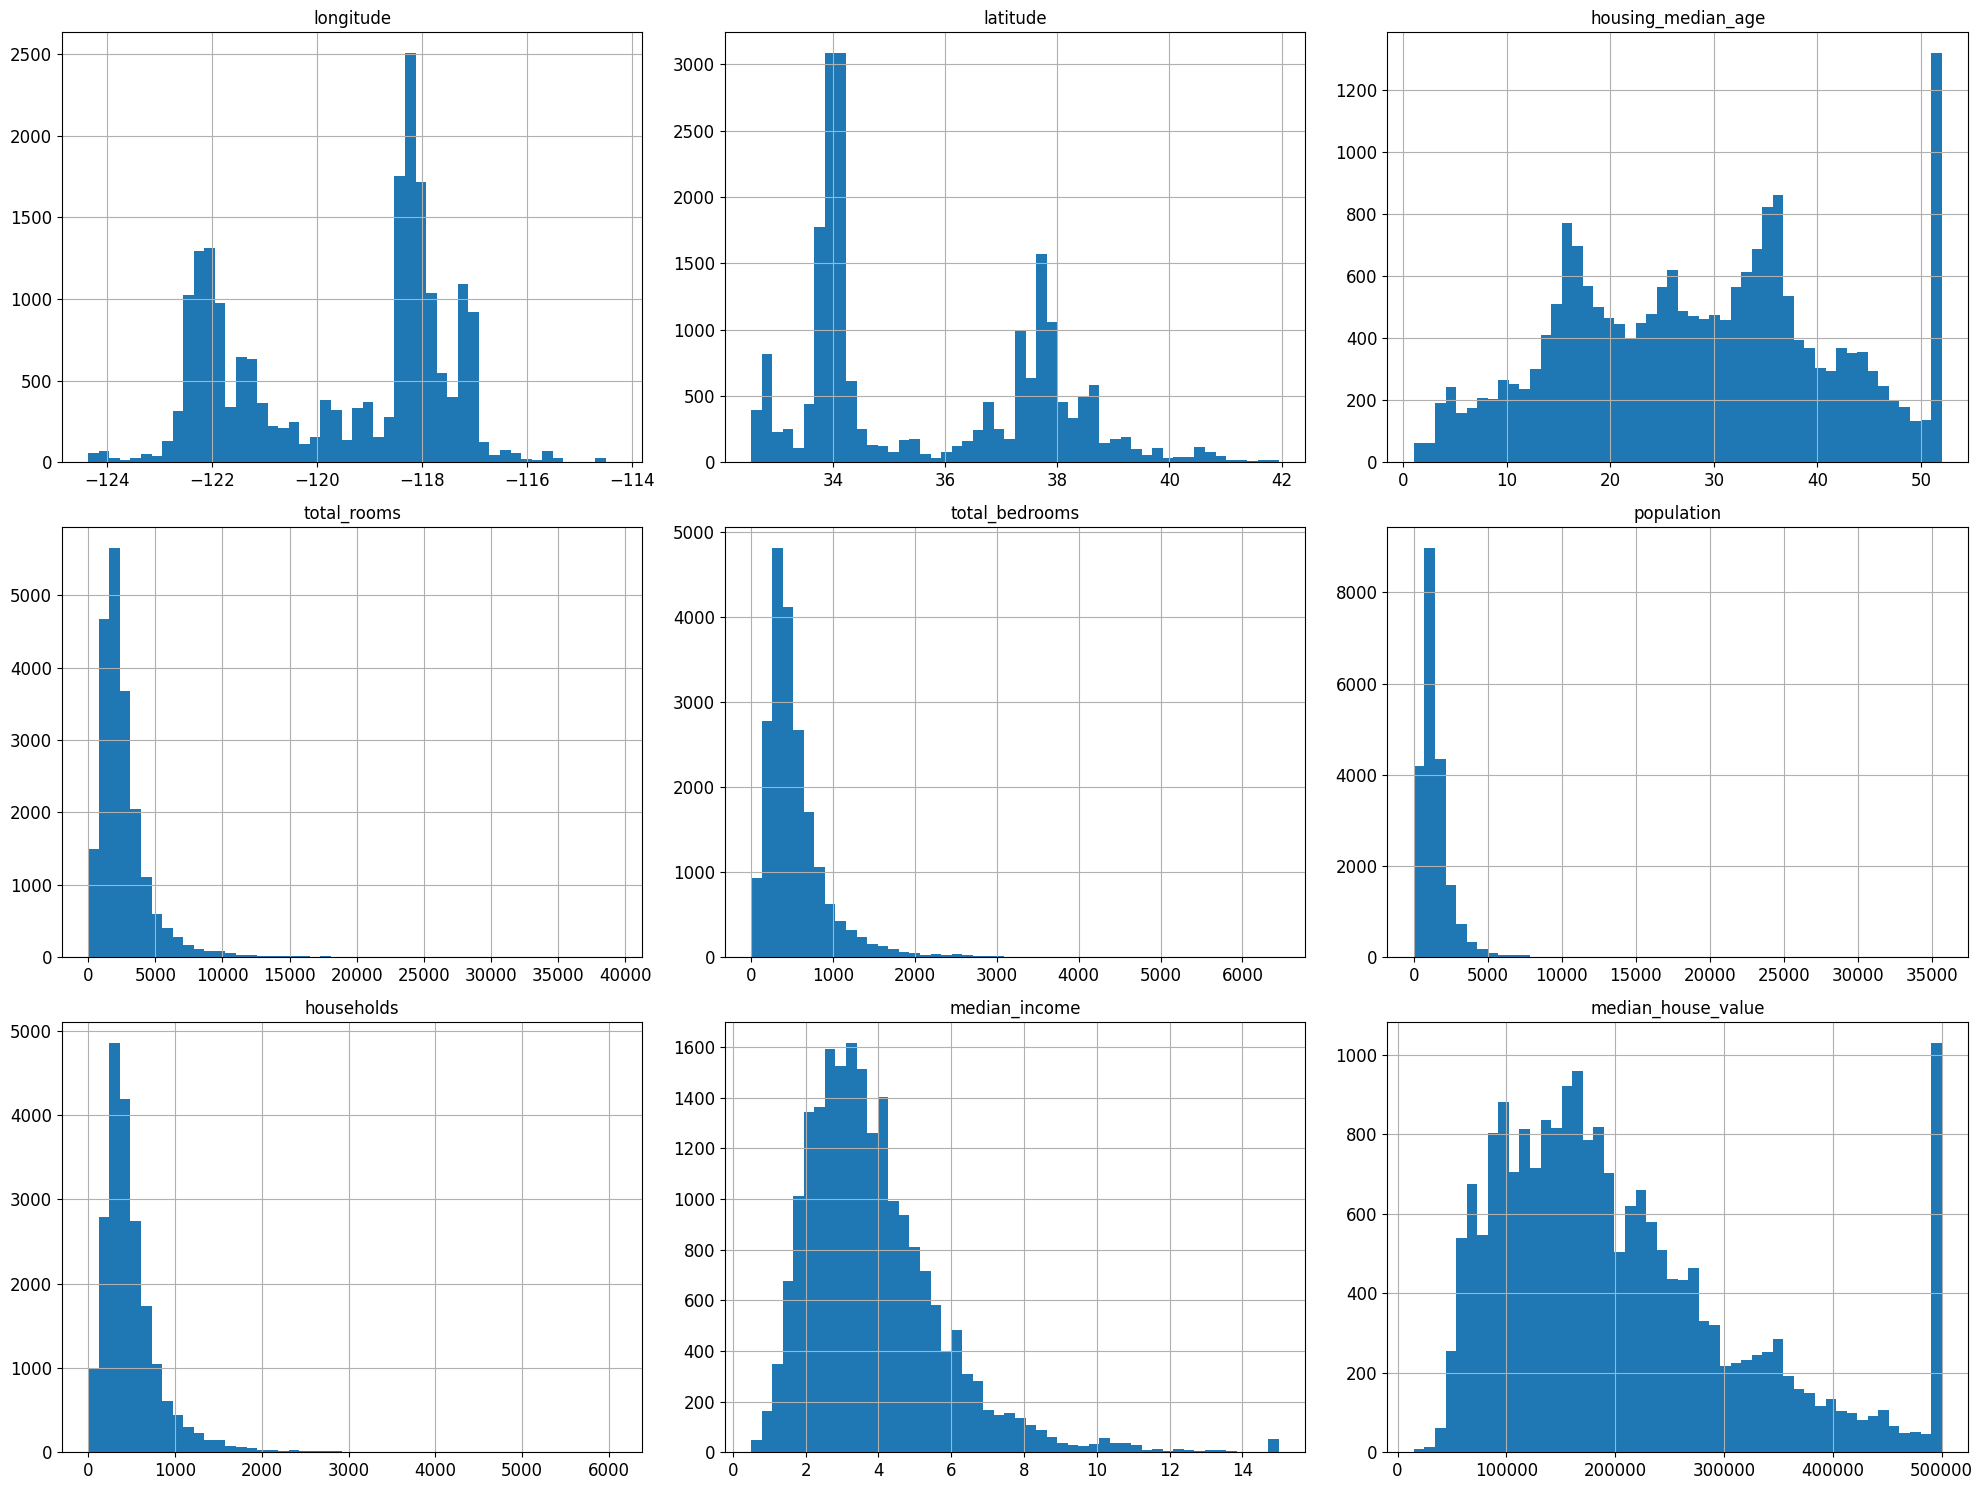

In [26]:
#@ Inspecting the Data using Histograms:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))  
save_fig("Histogram Plots")              
plt.show()     

In [27]:
#@ Splitting the Dataset:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=11)

#@ Inspecting the Dataset:
print(f"Training set: {len(train_set)}")                                             # Number of Training Dataset.
print(f"\nTesting set: {len(test_set)}")                                             # Number of Testing Dataset.
IPython.display.display(train_set.head(3))    
print("\n")                    
IPython.display.display(test_set.head(3))

Training set: 16512

Testing set: 4128


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20025,-119.05,36.07,21.0,2472.0,523.0,1238.0,504.0,1.7756,62900.0,INLAND
10772,-117.89,33.66,32.0,2736.0,550.0,1279.0,534.0,5.5422,253100.0,<1H OCEAN
16691,-120.61,35.13,16.0,3431.0,721.0,1777.0,701.0,2.7301,190400.0,<1H OCEAN


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2734,-115.56,32.78,34.0,2856.0,555.0,1627.0,522.0,3.2083,76200.0,INLAND
9087,-118.17,34.66,9.0,1561.0,253.0,731.0,233.0,5.7049,173200.0,INLAND
15789,-122.40,37.78,52.0,464.0,202.0,286.0,148.0,1.6125,112500.0,NEAR BAY


<Axes: >

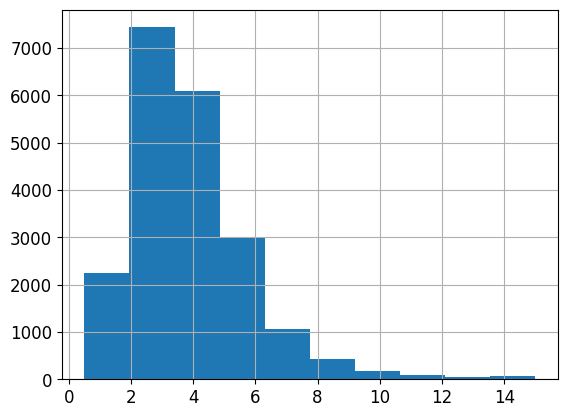

In [28]:
#@ Inspecting the median income attribute:
housing['median_income'].hist()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64




<Axes: >

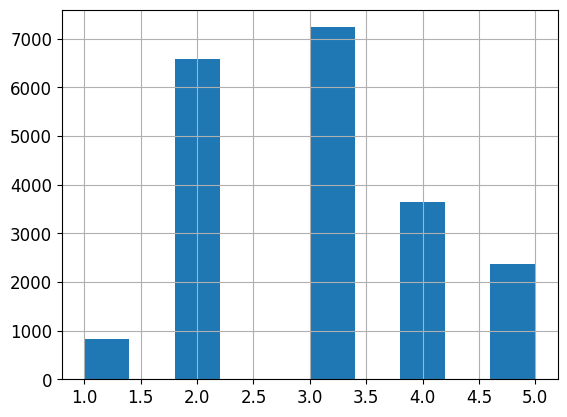

In [29]:
#@ Creating Income Cateogories:
housing['income_cat']=pd.cut(housing['median_income'],
                             bins=[0., 1.5, 3, 4.5, 6, np.inf], 
                             labels=[1, 2, 3, 4, 5])

#@ Inspecting the Income Categories:
print(housing['income_cat'].value_counts())
print('\n')
housing['income_cat'].hist()

In [30]:
#@ Stratified Sampling based on Income Category

from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]



In [31]:
#@ Removing the income Cat from the Data

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

Saving Figure Geographical Plot


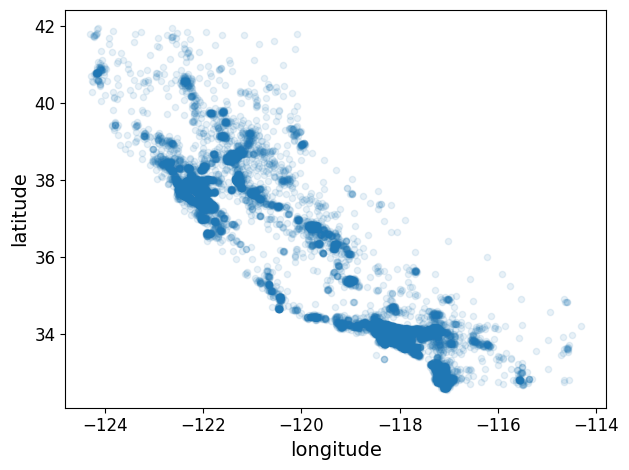

In [32]:
#@ Data Visualization

#@ creating the copy of training set:
housing=strat_train_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
save_fig('Geographical Plot')

Saving Figure Geometrical Plots


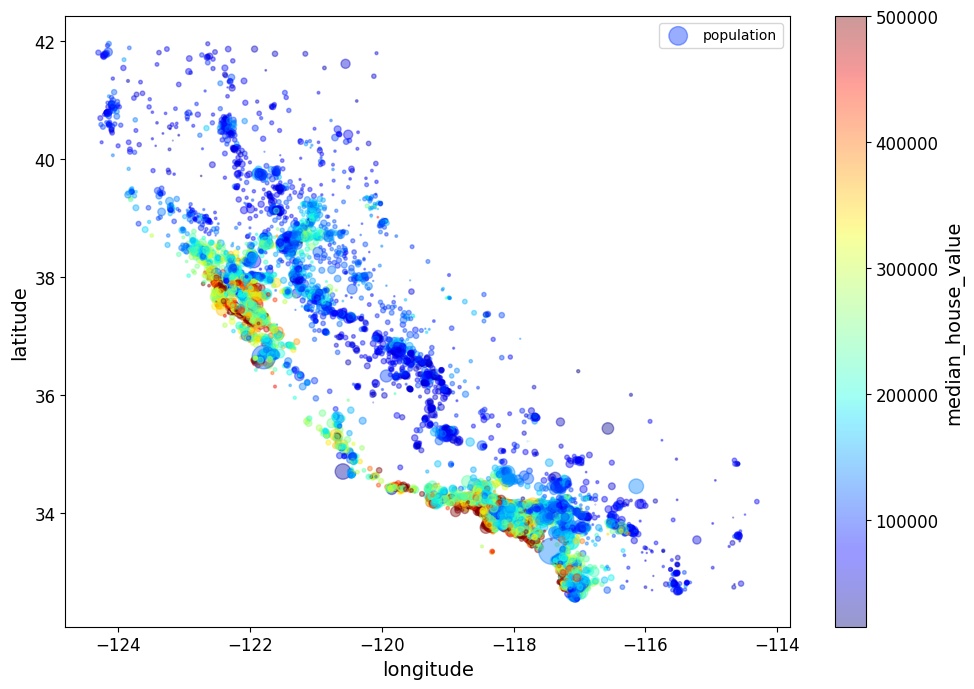

In [33]:
#@ Visualizing the house prices
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
             s=housing['population']/100, label='population', figsize=(10, 7), 
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()
save_fig('Geometrical Plots')

#### Preparing Data for machine learning

In [34]:
housing=strat_train_set.drop('median_house_value', axis=1)
housing_labels=strat_train_set['median_house_value'].copy()

In [35]:
#@ Working on missing values:

sample_incomplete_rows=housing[housing.isnull().any(axis=1)].head()
IPython.display.display(sample_incomplete_rows)
sample_incomplete_rows.dropna(subset=['total_bedrooms'])
sample_incomplete_rows.drop('total_bedrooms', axis=1)
median=housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True)
print('\n')
IPython.display.display(sample_incomplete_rows)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4600,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,<1H OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,NEAR OCEAN
17928,-121.97,37.34,33.0,3162.0,NaN,1553.0,686.0,3.6682,<1H OCEAN
7330,-118.17,33.98,41.0,756.0,NaN,873.0,212.0,2.7321,<1H OCEAN
4043,-118.50,34.17,37.0,880.0,NaN,369.0,155.0,4.1429,<1H OCEAN


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4600,-118.27,34.04,13.0,1784.0,434.0,2158.0,682.0,1.7038,<1H OCEAN
20268,-119.18,34.19,19.0,2393.0,434.0,1938.0,762.0,1.6953,NEAR OCEAN
17928,-121.97,37.34,33.0,3162.0,434.0,1553.0,686.0,3.6682,<1H OCEAN
7330,-118.17,33.98,41.0,756.0,434.0,873.0,212.0,2.7321,<1H OCEAN
4043,-118.50,34.17,37.0,880.0,434.0,369.0,155.0,4.1429,<1H OCEAN


- Scikit Learn provides a handy class to take care of missing values: Simple Imputer. I will create the Imputer instance and replace the missing values with median of the attribute. Since the median can be calculated only on the numerical attributes, I will create the copy of Data without the text attribute ocean proximity.

In [36]:
#@ Missing Data:

imputer=SimpleImputer(strategy='median')
housing_num=housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)
X=imputer.transform(housing_num)
housing_imputed=pd.DataFrame(X, columns=housing_num.columns)
print('\n')
IPython.display.display(housing_imputed.head())

[-118.5      34.26     29.     2125.      434.     1166.      409.
    3.5313]
[-118.5      34.26     29.     2125.      434.     1166.      409.
    3.5313]




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-117.46,34.09,8.0,4711.0,963.0,3310.0,988.0,3.5488
1,-116.94,32.78,17.0,13559.0,2656.0,6990.0,2533.0,3.4340
2,-118.27,34.04,13.0,1784.0,434.0,2158.0,682.0,1.7038
3,-119.75,36.75,50.0,1515.0,294.0,852.0,297.0,1.9955
4,-122.42,37.77,52.0,1086.0,349.0,589.0,361.0,2.5186


## Handling Text and Categorical attributes



In [37]:
housing_cat=housing[['ocean_proximity']]
print(housing_cat.head())

Ordinal_encoder=OrdinalEncoder()
housing_cat_encoded=Ordinal_encoder.fit_transform(housing_cat)
IPython.display.display(housing_cat_encoded[:10])      
print("\n")
print(Ordinal_encoder.categories_)


      ocean_proximity
13406          INLAND
15049       <1H OCEAN
4600        <1H OCEAN
2109           INLAND
15760        NEAR BAY


array([[1.],
       [0.],
       [0.],
       [1.],
       [3.],
       [0.],
       [1.],
       [4.],
       [0.],
       [1.]])



[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


- One issue with this representation is that ML Algorithms assume that the two nearby values are more similar than two distant values. So, I will apply the process of One Hot Encoding. Scikit Learn provides OneHotEncoder class to convert Categorical values into One Hot Vectors. The new attributes are called dummy attributes.

In [38]:
cat_encoder=OneHotEncoder(sparse_output=False)
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
print(housing_cat_1hot[:10])                                                 # Converting into numpy arrays.
print("\n")
print(cat_encoder.categories_)   

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
